In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading the datasets
client_path = "client.csv"
invoice_path = "invoice.csv"

client_df = pd.read_csv(client_path)
invoice_df = pd.read_csv(invoice_path)

# Converting to datetime format

As the dates in the datasets are not in a standard format, all dates will be converted to datetime format.

In [ ]:
# Converting to datetime format
client_df["date"] = pd.to_datetime(client_df["date"], errors = "coerce", dayfirst = True)
invoice_df["date"] = pd.to_datetime(invoice_df["date"], errors = "coerce", dayfirst = True)

# Dropping rows with missing/invalid IDs
client_df.dropna(subset = ["id"], inplace = True)
invoice_df.dropna(subset = ["id"], inplace = True)

# Feature aggregation

As a change from V2, instead of compiling data as a time series, data will be compiled by client number instead.

The new engineered features include:
1. Consommation_level_(1-4): Mean, Max, Standard Deviation and Sum
2. Consommation_level_(1-4): Sum by year (temporal trends)
3. Months_number: Mean, Max, Standard
4. Counter_statue: To count the number of anomalies

These new features are engineered in an effort to aid the XGBoost and Logistic Regression models in classifying fraud.

The new features are then merged with the existing `client.csv` dataset, with missing values being set to 0.

In [ ]:
# Aggregating invoice data by client ID
agg_features = invoice_df.groupby("id").agg({
    'consommation_level_1': ['mean', 'max', 'std', 'sum'],
    'consommation_level_2': ['mean', 'max', 'std', 'sum'],
    'consommation_level_3': ['mean', 'max', 'std', 'sum'],
    'consommation_level_4': ['mean', 'max', 'std', 'sum'],
    'months_number': ['mean', 'max', 'std'],
    'counter_statue': lambda x: (x == 1).sum(),  # Count anomalies
}).reset_index()

# Flattening multi-level cols
agg_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_features.columns]

# Merging with client data
merged_df = pd.merge(client_df, agg_features, left_on = 'id', right_on = 'id_', how = 'left')

print(merged_df.head())

   region       date  dis      id  catg  target     id_  \
0     301 1986-03-13   62      10    11       0      10   
1     105 1996-07-11   69     100    11       0     100   
2     303 2014-10-14   62    1000    11       0    1000   
3     101 2011-10-25   60  100003    11       0  100003   
4     311 2006-06-30   63  100004    12       0  100004   

   consommation_level_1_mean  consommation_level_1_max  \
0                 798.611111                      2400   
1                   1.200000                        15   
2                 663.714286                       800   
3                 850.800000                      1200   
4                 216.230769                       658   

   consommation_level_1_std  ...  consommation_level_3_std  \
0                513.841374  ...                  0.000000   
1                  3.607011  ...                  0.000000   
2                224.831365  ...                289.433294   
3                388.977120  ...                

In [ ]:
# Adding temporal features
invoice_df['year'] = invoice_df['date'].dt.year
invoice_df['month'] = invoice_df['date'].dt.month

# Calculating yearly consumption trends/client
yearly_trends = invoice_df.groupby(['id', 'year']).agg({
    'consommation_level_1': 'sum',
    'consommation_level_2': 'sum',
    'consommation_level_3': 'sum',
    'consommation_level_4': 'sum'
}).reset_index()

# Pivoting yearly trends
yearly_trends_pivot = yearly_trends.pivot(index = 'id', columns = 'year').fillna(0)
yearly_trends_pivot.columns = [f"{col[0]}_{col[1]}" for col in yearly_trends_pivot.columns]

# Merging to main dataset
merged_df = pd.merge(merged_df, yearly_trends_pivot, left_on = 'id', right_index = True, how = 'left')

print(merged_df.head())

   region       date  dis      id  catg  target     id_  \
0     301 1986-03-13   62      10    11       0      10   
1     105 1996-07-11   69     100    11       0     100   
2     303 2014-10-14   62    1000    11       0    1000   
3     101 2011-10-25   60  100003    11       0  100003   
4     311 2006-06-30   63  100004    12       0  100004   

   consommation_level_1_mean  consommation_level_1_max  \
0                 798.611111                      2400   
1                   1.200000                        15   
2                 663.714286                       800   
3                 850.800000                      1200   
4                 216.230769                       658   

   consommation_level_1_std  ...  consommation_level_4_2010.0  \
0                513.841374  ...                          0.0   
1                  3.607011  ...                          0.0   
2                224.831365  ...                          0.0   
3                388.977120  ...    

In [ ]:
# Filling missing values with zeros
merged_df.fillna(0, inplace = True)
merged_df.to_csv("aggregated_datasetV3.csv", index = False)

print("Dataset saved!")

Dataset saved!


# Imbalance Visualisation
By separating and counting the values of fraud and non-fraud cases, it's clear to see that there is a heavy imabalance between the two classes. This suggests that measures will need to be taken to counter this.

<ipython-input-10-85f8385d474d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "target", data = merged_df, palette = "viridis")


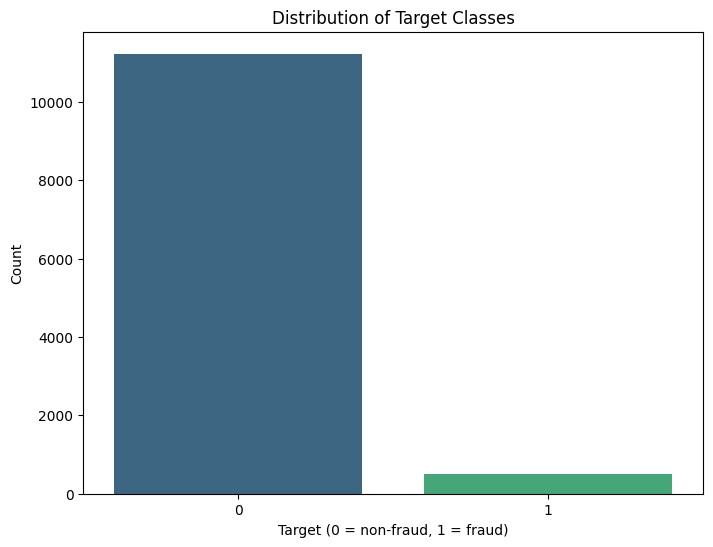

In [ ]:
plt.figure(figsize = (8, 6))
sns.countplot(x = "target", data = merged_df, palette = "viridis")
plt.title("Distribution of Target Classes")
plt.xlabel("Target (0 = non-fraud, 1 = fraud)")
plt.ylabel("Count")
plt.show()

# Dataset correlation heatmap

A correlation heatmap was generated for the saved dataset to display the correlation between features. This was done after training and testing the XGBoost and Logistic Regression models, in an effort to ascertain the reason of the low precision of both models.

In [ ]:
# Loading aggregated dataset
aggregated_invoice = pd.read_csv("aggregated_datasetV3.csv")
aggregated_invoice.columns

Index(['region', 'date', 'dis', 'id', 'catg', 'target', 'id_',
       'consommation_level_1_mean', 'consommation_level_1_max',
       'consommation_level_1_std',
       ...
       'consommation_level_4_2010.0', 'consommation_level_4_2011.0',
       'consommation_level_4_2012.0', 'consommation_level_4_2013.0',
       'consommation_level_4_2014.0', 'consommation_level_4_2015.0',
       'consommation_level_4_2016.0', 'consommation_level_4_2017.0',
       'consommation_level_4_2018.0', 'consommation_level_4_2019.0'],
      dtype='object', length=195)

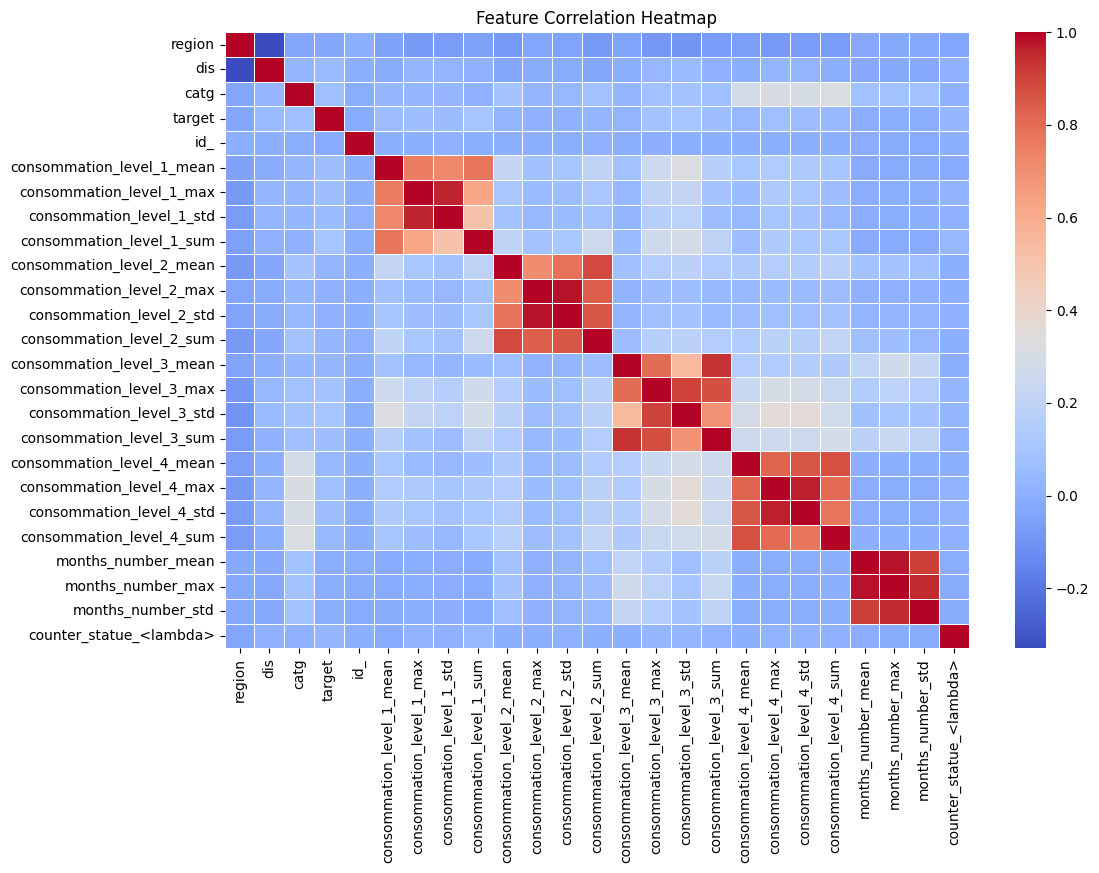

In [ ]:
# Compute correlation matrix
numeric_invoice = aggregated_invoice.drop(aggregated_invoice.iloc[:, 27:].columns, axis = 1)
numeric_invoice = numeric_invoice.drop(columns =['date', 'id'])
corr_matrix = numeric_invoice.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

As seen from the above, there is weak correlation between the target category and all other categories (besides itself). Hence, this may be why the models struggle to classify fraud, explaining the low precision and AUC score.